In [1]:
print("all ok")

all ok


In [5]:
import sys, os

# Get project root — one level up from 'research_and_analyst'
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)

print("Project root added to path:", project_root)

Project root added to path: c:\Users\Sunny\automated-research-report-generation


In [6]:
from research_and_analyst.utils.model_loader import ModelLoader

In [7]:
model_loader = ModelLoader()

{"timestamp": "2025-10-05T10:01:43.866851Z", "level": "info", "event": "OPENAI_API_KEY loaded from environment"}
{"timestamp": "2025-10-05T10:01:43.867998Z", "level": "info", "event": "GOOGLE_API_KEY loaded from environment"}
{"timestamp": "2025-10-05T10:01:43.868999Z", "level": "info", "event": "GROQ_API_KEY loaded from environment"}
{"timestamp": "2025-10-05T10:01:43.868999Z", "level": "warning", "event": "ASTRA_DB_API_ENDPOINT is missing from environment"}
{"timestamp": "2025-10-05T10:01:43.869998Z", "level": "warning", "event": "ASTRA_DB_APPLICATION_TOKEN is missing from environment"}
{"timestamp": "2025-10-05T10:01:43.870999Z", "level": "warning", "event": "ASTRA_DB_KEYSPACE is missing from environment"}
{"config_keys": ["astra_db", "embedding_model", "retriever", "llm"], "timestamp": "2025-10-05T10:01:43.871999Z", "level": "info", "event": "YAML config loaded"}


In [8]:
llm=model_loader.load_llm()

{"provider": "openai", "model": "gpt-4o", "timestamp": "2025-10-05T10:01:44.826617Z", "level": "info", "event": "Loading LLM"}


In [9]:
llm.invoke("hi").content

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


'Hello! How can I assist you today?'

In [10]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

In [34]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver

#health

Analyst(
        name="Dr. Neha Patel",
        role="Medical Data Scientist",
        affiliation="Stanford Medicine",
        description="Focuses on predictive models for patient outcomes."
        ),

Analyst(
    name="Dr. Arun Verma",
    role="Ethics Researcher",
    affiliation="WHO",
    description="Explores ethical implications of AI in diagnostics."
),
Analyst(
    name="Ms. Priya Sharma",
    role="Policy Analyst",
    affiliation="Ministry of Health",
    description="Investigates AI policy and compliance frameworks."
)

In [31]:
class Analyst(BaseModel):
    name: str = Field(description="Name of the analyst.")
    role: str = Field(description="Role of the analyst in the context of the topic.")
    affiliation: str = Field(description="Primary affiliation of the analyst.")
    description: str = Field(description="Description of the analyst focus, concerns, and motives.")
    
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"
    

In [32]:
Analyst(
    name="sunny savita",
    role="genai eng",
    affiliation="AI Research LAB",
    description="I am genai developer as well as mentor"
    )

Analyst(name='sunny savita', role='genai eng', affiliation='AI Research LAB', description='I am genai developer as well as mentor')

In [22]:
analyst = Analyst(
    name="sunny savita",
    role="genai eng",
    affiliation="AI Research LAB",
    description="I am genai developer as well as mentor"
    )

In [23]:
analyst.name

'sunny savita'

In [26]:
analyst.role

'genai eng'

In [27]:
analyst.affiliation

'AI Research LAB'

In [25]:
print(analyst.persona)

Name: sunny savita
Role: genai eng
Affiliation: AI Research LAB
Description: I am genai developer as well as mentor



In [33]:
class Perspectives(BaseModel):
       analysts: List[Analyst] = Field(description="Comprehensive list of analysts with their roles and affiliations.")

In [29]:
class GenerateAnalystsState(TypedDict):
    topic: str #research topic
    max_analysts: int # number of analyst
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    

In [30]:
GenerateAnalystsState(
    topic = "finance",
    max_analysts= 5,
    human_analyst_feedback= "give the real info",  
)

{'topic': 'finance',
 'max_analysts': 5,
 'human_analyst_feedback': 'give the real info'}

In [ ]:
Analyst(
        name="Dr. Neha Patel",
        role="Medical Data Scientist",
        affiliation="Stanford Medicine",
        description="Focuses on predictive models for patient outcomes."
    ),

In [36]:
analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

In [40]:
print([analyst_instructions.format(
        topic="education",
        max_analysts=4,
        human_analyst_feedback="please exaplain only on AI"
        
        )] + ["Generate the set of analysts."])

['You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:\n\n1. First, review the research topic:\neducation\n\n2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: \n\nplease exaplain only on AI\n\n3. Determine the most interesting themes based upon documents and / or feedback above.\n\n4. Pick the top 4 themes.\n\n5. Assign one analyst to each theme.', 'Generate the set of analysts.']


['You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:\n\n1. First, review the research topic:\neducation\n\n2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: \n\nplease exaplain only on AI\n\n3. Determine the most interesting themes based upon documents and / or feedback above.\n\n4. Pick the top 4 themes.\n\n5. Assign one analyst to each theme.', 'Generate the set of analysts.']

In [43]:
def create_analyst(state:GenerateAnalystsState):
    """
    it is creating my analyst
    
    """
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback","")
    
    structured_llm = llm.with_structured_output(Perspectives)
    
    system_messages = analyst_instructions.format(
        topic=topic,
        max_analysts=max_analysts,
        human_analyst_feedback=human_analyst_feedback
        
        )
    analysts = structured_llm.invoke([SystemMessage(content=system_messages)]+ [HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}
    

In [45]:
create_analyst(
    {'topic': 'health',
    'max_analysts': 2,
    'human_analyst_feedback': 'give the real info'}
    )

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'analysts': [Analyst(name='Dr. Emily Chen', role='Public Health Researcher', affiliation='World Health Organization', description='Dr. Emily Chen focuses on global health trends and the impact of public health policies on population health outcomes. Her primary concern is understanding how different health interventions can be optimized to improve public health, especially in low-resource settings. She is motivated by the need to provide evidence-based recommendations to policymakers to enhance health systems worldwide.'),
  Analyst(name='Dr. Raj Patel', role='Healthcare Technology Analyst', affiliation='Harvard T.H. Chan School of Public Health', description='Dr. Raj Patel specializes in the intersection of healthcare and technology, analyzing how digital health innovations can transform patient care and health management. His focus is on evaluating the effectiveness and accessibility of health technologies, such as telemedicine and wearable health devices, in improving patient outco

In [46]:
def human_feedback(state):
    """ No-op node that should be interrupted on """
    pass

In [47]:
def should_continue(state):
    """ Return the next node to execute """
    human_analyst_feedback = state.get("human_analyst_feedback",None)
    if human_analyst_feedback:
        return "create_analyst"

In [48]:
from IPython.display import Image, display

In [56]:
builder = StateGraph(GenerateAnalystsState)

In [57]:
builder.add_node("create_analyst",create_analyst)
builder.add_node("human_feedback", human_feedback)

In [58]:
builder.add_edge(START,"create_analyst")
builder.add_edge("create_analyst", "human_feedback")
builder.add_conditional_edges("human_feedback",
                        should_continue,
                        ["create_analyst",
                        END])

In [59]:
memory = MemorySaver()

In [60]:
graph = builder.compile(interrupt_before= ["human_feedback"],checkpointer= memory)

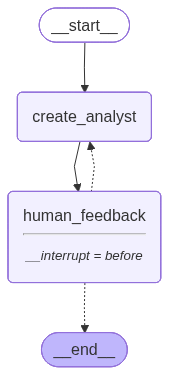

In [61]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [62]:
topic = "the benefits of adopting Langgraph as an agent framework"

In [63]:
max_analysts = 4

In [64]:
thread =  {"configurable":{"thread_id":1}}

In [65]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  
            
        

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Dr. Emily Chen
Affiliation: Institute of Advanced AI Systems
Role: AI Framework Specialist
Description: Dr. Chen focuses on the technical advantages of adopting Langgraph as an agent framework. Her primary interest lies in how Langgraph enhances the efficiency and scalability of AI systems. She is particularly concerned with the framework's ability to integrate with existing technologies and its potential to streamline complex AI processes.
--------------------------------------------------
Name: Michael O'Neill
Affiliation: Tech Innovations Inc.
Role: Enterprise Solutions Consultant
Description: Michael is interested in the business implications of adopting Langgraph. He explores how the framework can drive innovation and competitive advantage for enterprises. His focus is on cost-effectiveness, return on investment, and the framework's ability to support rapid deployment of AI solutions in various industries.
--------------------------------------------------
Name: Dr. Aisha Pa

In [66]:
state = graph.get_state(thread)

In [67]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'analysts': [Analyst(name='Dr. Emily Chen', role='AI Framework Specialist', affiliation='Institute of Advanced AI Systems', description="Dr. Chen focuses on the technical advantages of adopting Langgraph as an agent framework. Her primary interest lies in how Langgraph enhances the efficiency and scalability of AI systems. She is particularly concerned with the framework's ability to integrate with existing technologies and its potential to streamline complex AI processes."), Analyst(name="Michael O'Neill", role='Enterprise Solutions Consultant', affiliation='Tech Innovations Inc.', description="Michael is interested in the business implications of adopting Langgraph. He explores how the framework can drive innovation and competitive advantage for enterprises. His focus is on cost-effectiveness, return on investment, and the framework's ability to support rapid deployment of AI

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'analysts': [Analyst(name='Dr. Emily Chen', role='AI Framework Specialist', affiliation='Institute of Advanced AI Systems', description="Dr. Chen focuses on the technical advantages of adopting Langgraph as an agent framework. Her primary interest lies in how Langgraph enhances the efficiency and scalability of AI systems. She is particularly concerned with the framework's ability to integrate with existing technologies and its potential to streamline complex AI processes."), Analyst(name="Michael O'Neill", role='Enterprise Solutions Consultant', affiliation='Tech Innovations Inc.', description="Michael is interested in the business implications of adopting Langgraph. He explores how the framework can drive innovation and competitive advantage for enterprises. His focus is on cost-effectiveness, return on investment, and the framework's ability to support rapid deployment of AI solutions in various industries."), Analyst(name='Dr. Aisha Patel', role='Ethics and Compliance Analyst', affiliation='Global AI Ethics Consortium', description='Dr. Patel examines the ethical considerations and compliance aspects of using Langgraph. She is concerned with ensuring that the framework adheres to global standards for AI ethics and data privacy. Her analysis includes the potential risks and safeguards associated with deploying Langgraph in sensitive environments.'), Analyst(name='Carlos Ramirez', role='User Experience Researcher', affiliation='Human-Centric AI Lab', description='Carlos focuses on the user experience and accessibility of Langgraph. He investigates how the framework impacts the usability of AI systems for developers and end-users. His primary concern is ensuring that Langgraph is intuitive and accessible, promoting wider adoption and effective use across diverse user groups.')]}, next=('human_feedback',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0a1de3-2570-6c27-8001-9078a254da36'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-10-05T11:26:54.786256+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0a1de2-fb55-6ac3-8000-c6b465b474b8'}}, tasks=(PregelTask(id='91c5d388-aa45-dddb-1ccb-71d005fa101b', name='human_feedback', path=('__pregel_pull', 'human_feedback'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [68]:
state.next

('human_feedback',)

In [69]:
graph.update_state(thread,
                   {"human_analyst_feedback":"add something from the startup perspective and focus on the latest enterprise application"},as_node="human_feedback"
                   )

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0a1def-b93a-64bb-8002-d51dc9d3160e'}}

In [70]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Chen
Affiliation: Institute of Advanced AI Systems
Role: AI Framework Specialist
Description: Dr. Chen focuses on the technical advantages of adopting Langgraph as an agent framework. Her primary interest lies in how Langgraph enhances the efficiency and scalability of AI systems. She is particularly concerned with the framework's ability to integrate with existing technologies and its potential to streamline complex AI processes.
--------------------------------------------------
Name: Michael O'Neill
Affiliation: Tech Innovations Inc.
Role: Enterprise Solutions Consultant
Description: Michael is interested in the business implications of adopting Langgraph. He explores how the framework can drive innovation and competitive advantage for enterprises. His focus is on cost-effectiveness, return on investment, and the framework's ability to support rapid deployment of AI solutions in various industries.
--------------------------------------------------
Name: Dr. Aisha Pa

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Sophia Tran
Affiliation: Tech Innovators Network
Role: Startup Ecosystem Analyst
Description: Sophia focuses on the impact of adopting new technologies like Langgraph within startup environments. She is particularly interested in how Langgraph can streamline operations, reduce costs, and enhance scalability for emerging companies. Her analysis often includes case studies of startups that have successfully integrated Langgraph into their frameworks.
--------------------------------------------------
Name: Michael Chen
Affiliation: Global Enterprise Solutions
Role: Enterprise Application Specialist
Description: Michael specializes in the latest enterprise applications and how frameworks like Langgraph can be leveraged to improve efficiency and innovation. He examines the integration of Langgraph in large-scale operations, focusing on its ability to enhance data processing and decision-making capabilities in complex enterprise environments.
------------------------------------------